In [2]:
import pandas as pd
import numpy as np
import re
from sklearn import linear_model
from textblob import TextBlob 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [9]:
import os
os.chdir('E:\Github Projects\CEO-Tweets-Analysis\Dataset')
#Import the CEO tweets file
ceo_tweets=pd.read_csv('ceo_tweets_final.csv')
print(ceo_tweets[:5])
print(len(ceo_tweets))

   Unnamed: 0   username                   id                 date  \
0           0  @tim_cook  1200060640469159939  2019-11-28 14:35:27   
1           1  @tim_cook  1200047686180835328  2019-11-28 13:43:58   
2           2  @tim_cook  1199872990718169089  2019-11-28 02:09:48   
3           3  @tim_cook  1199855397617704970  2019-11-28 00:59:53   
4           4  @tim_cook  1199767313890922497  2019-11-27 19:09:52   

                                               tweet  retweets  likes  
0  On this #Thanksgiving, I am reflecting on the ...       546   4434  
1  Wishing everyone a #HappyThanksgiving filled w...       575   6097  
2  Tomorrow the incredible @MNightShyamalan’s ser...       412   2607  
3  Thanksgiving Day challenge! Close your rings w...       394   3932  
4  As many of you travel to be with loved ones to...      1310   8436  
60947


In [10]:
#Data Manipulation
ceo_tweets['date']=pd.to_datetime(ceo_tweets['date'])
ceo_tweets=ceo_tweets[ceo_tweets['date'].dt.year>2016]
ceo_tweets['date']=ceo_tweets['date'].apply(lambda X: X.date())

In [11]:
ceo_tweets.groupby(['username'])['tweet'].count()

username
@Benioff            3230
@BillGates           983
@Bill_Gross         1463
@BoeingCEO           450
@ChuckRobbins        996
@IndraNooyi          147
@JeffBezos           150
@JohnLegere         3236
@LisaSu              172
@MichaelDell        1020
@WaltBettinger       449
@anandmahindra      3221
@aneelb              100
@bchesky             650
@drewhouston          75
@eldsjal             486
@elonmusk           3247
@jack               3225
@levie               538
@lloydblankfein       68
@marissamayer         78
@mtbarra             212
@richardbranson     3221
@rupertmurdoch         1
@satyanadella        501
@sundarpichai        432
@tim_cook            610
@toddmckinnon        181
@tonyfernandes      3196
@westernunionCEO     916
Name: tweet, dtype: int64

In [12]:
def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) #(@[A-Za-z0-9]+)|

In [13]:
ceo_tweets['clean_tweets']=ceo_tweets['tweet'].map(clean_tweet)
ceo_tweets['tweet']=ceo_tweets['tweet'].map(str.lower)
ceo_tweets.head()

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...


In [14]:

# Sentiment Analysis functions:

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        return analysis.sentiment.polarity
    
def sentiment_buckets(score):
        ''' 
        Utility function to classify the sentiment bucket 
        '''
        # set sentiment : 5% offset
        if score > 0.05: 
            return 'positive'
        elif score < -0.05: 
            return 'negative'
        else: 
            return 'neutral'


In [15]:
# create sentiment score and sentiment bucket columns
ceo_tweets['sentiment_score']=ceo_tweets['clean_tweets'].map(get_tweet_sentiment)
ceo_tweets['sentiment_bucket']=ceo_tweets['sentiment_score'].map(sentiment_buckets)
ceo_tweets[:5]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive


## Sentiment EDA:

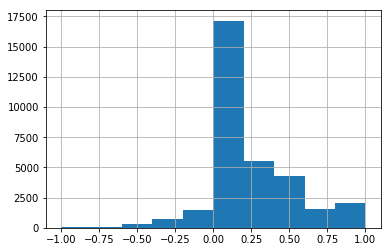

In [16]:
# sentiment EDA :
# Sentiment polarity distrution
ceo_tweets['sentiment_score'].hist()

In [17]:
# CEO level sentiment EDA:
# sentiment score statistics 
ceo_tweets.groupby('username')['sentiment_score'].agg(['min','max','mean','median'])

,min,max,mean,median
username,,,,
@Benioff,-1.000000,1.0,0.178951,0.100000
@BillGates,-1.000000,1.0,0.221416,0.200000
@Bill_Gross,-1.000000,1.0,0.190096,0.150000
@BoeingCEO,-0.500000,1.0,0.288584,0.250000
@ChuckRobbins,-1.000000,1.0,0.384362,0.400000
@IndraNooyi,-0.800000,1.0,0.270405,0.250000
@JeffBezos,-0.250000,1.0,0.253642,0.201389
@JohnLegere,-1.000000,1.0,0.190867,0.000000
@LisaSu,0.000000,1.0,0.442633,0.430000


In [18]:
# sentiment score table to calculate % distrbution for sentiment buckets
df_sent_bucket=pd.DataFrame(ceo_tweets.groupby(['username','sentiment_bucket'])['sentiment_score'].agg('count'))
df_sent_bucket=df_sent_bucket.reset_index()
df_sent_bucket.columns=['username','sentiment_bucket','tweet_cnt']
df_sent_bucket[:5]

,username,sentiment_bucket,tweet_cnt
0,@Benioff,negative,254
1,@Benioff,neutral,1255
2,@Benioff,positive,1721
3,@BillGates,negative,96
4,@BillGates,neutral,255


In [19]:
#Pivot the results
df_sent_pivot=pd.pivot_table(df_sent_bucket,index=['username'],columns=['sentiment_bucket']).fillna(0)
df_sent_pivot['perc_negative']=df_sent_pivot['tweet_cnt']['negative']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_positive']=df_sent_pivot['tweet_cnt']['positive']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_neutral']=df_sent_pivot['tweet_cnt']['neutral']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot.head()

tweet_cnt                  perc_negative perc_positive  \
sentiment_bucket  negative neutral positive                               
username                                                                  
@Benioff             254.0  1255.0   1721.0      7.863777     53.281734   
@BillGates            96.0   255.0    632.0      9.766022     64.292981   
@Bill_Gross          143.0   454.0    866.0      9.774436     59.193438   
@BoeingCEO            10.0   101.0    339.0      2.222222     75.333333   
@ChuckRobbins         38.0   215.0    743.0      3.815261     74.598394   

                 perc_neutral  
sentiment_bucket               
username                       
@Benioff            38.854489  
@BillGates          25.940997  
@Bill_Gross         31.032126  
@BoeingCEO          22.444444  
@ChuckRobbins       21.586345

In [20]:
# Levie analysis
ceo_tweets[(ceo_tweets['username']=='@lloydblankfein') & (ceo_tweets['sentiment_score']<-0.05 )][['tweet','username','sentiment_score']].sort_values(by='sentiment_score',ascending = True)

,tweet,username,sentiment_score
34906,still thinking about #bitcoin. no conclusion -...,@lloydblankfein,-0.500000
34877,the house not focusing on anti-semitism but in...,@lloydblankfein,-0.483333
34922,leadership helps 🇺🇸our language is dominant; $...,@lloydblankfein,-0.350000
34878,"after killing amazon's nyc hq, not sure some p...",@lloydblankfein,-0.250000
34867,uh-oh. can another round of tariffs be far beh...,@lloydblankfein,-0.166667
34866,don't know why sen. sanders picks on a retiree...,@lloydblankfein,-0.155556
34914,"every now and then, david lets his hair down.....",@lloydblankfein,-0.155556
34919,congrats to @jeffimmelt for leading ge thru 9/...,@lloydblankfein,-0.150000
34909,immigration is a complex issue but i wouldn't ...,@lloydblankfein,-0.150000
34917,rt @goldmansachs: $gs ceo @lloydblankfein on t...,@lloydblankfein,-0.100000


## Bag of Words Anaysis

In [21]:
# import the necessary libraries

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

ceo_tweets["clean_tweets"] = ceo_tweets["clean_tweets"].astype(str)
ceo_tweets["tweet_tokens"] = ceo_tweets["clean_tweets"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
ceo_tweets["tweet_tokens"] = ceo_tweets["tweet_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])

ceo_tweets[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nimesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nimesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da..."
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,..."
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series..."
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f..."
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p..."


In [23]:
#Obtain POS for the tokens
#import nltk
nltk.download('averaged_perceptron_tagger')
ceo_tweets['pos']=ceo_tweets['tweet_tokens'].apply(nltk.tag.pos_tag)
ceo_tweets[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nimesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens,pos
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da...","[(thanksgiving, VBG), (reflecting, VBG), (drea..."
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,...","[(wishing, VBG), (everyone, NN), (happythanksg..."
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series...","[(tomorrow, NN), (incredible, JJ), (mnightshya..."
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f...","[(thanksgiving, VBG), (day, NN), (challenge, V..."
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p...","[(many, JJ), (travel, NN), (loved, VBD), (ones..."


In [24]:
# Extract the list of nouns to create manual buckets based on them:
#ceo_tweets['nouns']=ceo_tweets['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
ceo_tweets['nouns']=ceo_tweets['pos'].apply(lambda pos_list:[x[0] for x in pos_list if x[1].startswith('NN')])
ceo_tweets[:5]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens,pos,nouns
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da...","[(thanksgiving, VBG), (reflecting, VBG), (drea...","[dreamers, day, friends, family]"
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,...","[(wishing, VBG), (everyone, NN), (happythanksg...","[everyone, joy, amp, happiness, today, thankf]"
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series...","[(tomorrow, NN), (incredible, JJ), (mnightshya...","[tomorrow, mnightshyamalan, series, servant, a..."
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f...","[(thanksgiving, VBG), (day, NN), (challenge, V...","[day, rings, family, badge]"
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p...","[(many, JJ), (travel, NN), (loved, VBD), (ones...","[travel, ones, today, thing, time, tog]"


In [25]:
#Filter the noun list only to make the list of attributes 
noun_lst = ceo_tweets['nouns'].apply(pd.Series).stack().unique()

# # get the frequencies for the nouns:
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']
noun_df[:5]

,nouns
0,dreamers
1,day
2,friends
3,family
4,everyone


In [26]:
## get frequency of all words
all_words=ceo_tweets['nouns'].sum()
freq_dist = nltk.FreqDist(all_words)

In [27]:
df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

In [28]:
noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')
noun_freq_df[:5]

,nouns,term,freq
0,dreamers,dreamers,32
1,day,day,879
2,friends,friends,129
3,family,family,260
4,everyone,everyone,443


In [45]:
# Export the file :
noun_freq_df.to_csv('nouns_tweets.csv')

In [29]:
#Function to get instagram info for the CEOs

import requests
import urllib.request
import urllib.parse
import urllib.error
from bs4 import BeautifulSoup
import ssl
import json

df_insta=pd.DataFrame(columns=['insta_user','insta_followers','insta_following','insta_posts'])

def get_insta_info(url):
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html, 'html.parser')
        data = soup.find_all('meta', attrs={'property': 'og:description'
                             })
        text = data[0].get('content').split()
        user = '%s %s %s' % (text[-3], text[-2], text[-1])
        followers = text[0]
        following = text[2]
        posts = text[4]
        print ('User:', user)
        print ('Followers:', followers)
        print ('Following:', following)
        print ('Posts:', posts)
        print ('---------------------------')
        df_insta.loc[len(df_insta)]=[user,followers,following,posts]
        print(df_insta)
        

get_insta_info('https://www.instagram.com/thisisbillgates/')

User: Bill Gates (@thisisbillgates)
Followers: 5.9m
Following: 36
Posts: 141
---------------------------
                      insta_user insta_followers insta_following insta_posts
0  Bill Gates (@thisisbillgates)            5.9m              36         141


## Tweet topics - manual way

In [34]:
# import the created manual topics
import os
os.chdir('E:\Github Projects\CEO-Tweets-Analysis\Dataset')
topic_df=pd.read_csv('topic_manual.csv')
topic_df

,Usernames,work,business,company,emotion,social,technology,general,personal,product,politics
0,@Benioff,293,706,641,353,721,198,235,139,177,69
1,@BillGates,81,145,11,124,440,83,68,61,27,21
2,@Bill_Gross,79,193,82,192,180,162,24,27,120,26
3,@BoeingCEO,148,146,213,83,78,22,6,14,73,2
4,@ChuckRobbins,253,298,470,275,141,54,26,67,38,12
5,@IndraNooyi,14,32,34,30,55,3,5,18,2,1
6,@JeffBezos,26,13,22,31,18,6,0,6,10,0
7,@JohnLegere,222,186,1092,375,70,34,53,67,205,7
8,@LisaSu,26,46,84,53,13,13,3,16,27,0
9,@MichaelDell,162,270,444,150,90,151,6,41,69,2


In [36]:
# import the company related financial factors and CEO related factors :
reg_ip_df=pd.read_csv('regression_ip.csv')
reg_ip_df[:5]

,Ticker,ceo,company,ceo_age,ceo_gender,ceo_compensation,glasdoor_ceo_approval,twitter_followers,perc_held_insiders_1,perc_held_institutions1,...,short_perc_float_nov,short_perc_shares_outstanding_nov,short_ratio_nov,total_cash,total_cash_per_share,tot_debt,total_debt_equity,trailing_annual_dividend_rate3,trailing_annual_dividend_yield3,trailing_pe
0,AABA,@marissamayer,yahoo,44,0.0,4.00,0.85,1624782,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,@tim_cook,apple,59,1.0,141.60,0.91,11599990,0.07,60.95,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.40,3.00,1.12,22.48
2,AMD,@LisaSu,amd,50,0.0,13.35,0.97,44516,0.80,66.97,...,11.06,10.44,2.18,1.210000e+09,1.09,1.110000e+09,51.06,NaN,NaN,204.97
3,AMZN,@JeffBezos,amazon,55,1.0,1.68,0.86,1108303,16.12,57.12,...,0.92,0.77,1.27,4.340000e+10,87.54,7.459000e+10,132.00,NaN,NaN,79.79
4,BA,@BoeingCEO,boeing,55,1.0,23.40,0.79,24172,0.07,70.56,...,1.08,1.08,1.06,1.091000e+10,19.39,2.588000e+10,NaN,7.88,2.14,55.11


In [38]:
cols=list(reg_ip_df.columns)[3:]
for i in cols:
    reg_ip_df[i] = reg_ip_df[i].fillna((reg_ip_df[i].mean()))
#reg_ip_df[.apply(lambda x: x.fillna(x.mean()),axis=0)

In [39]:
#lower-case the usernames in both the tables:

reg_ip_df['ceo']=reg_ip_df['ceo'].map(str.lower)
ceo_tweets['username']=ceo_tweets['username'].map(str.lower)

In [40]:
# Inner join on both the tables:

ceo_tweets_merge=ceo_tweets.merge(reg_ip_df, right_on='ceo',left_on='username',how='inner')
ceo_tweets_merge[:2]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,...,short_perc_float_nov,short_perc_shares_outstanding_nov,short_ratio_nov,total_cash,total_cash_per_share,tot_debt,total_debt_equity,trailing_annual_dividend_rate3,trailing_annual_dividend_yield3,trailing_pe
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.4,3.0,1.12,22.48
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.4,3.0,1.12,22.48


In [49]:
# # Quality Check
len(ceo_tweets) #33254
len(ceo_tweets_merge) #23741
ceo_tweets_merge.groupby(['username'])['tweet'].count()  # Looks fine
ceo_tweets_merge['company'].unique()

array(['apple', 'tesla', 'mahindra', nan, 'boeing', 'spotify', 'tmobile',
       'google', 'box', 'goldman', 'dell', 'news_corp', 'microsoft',
       'schwabs', 'yahoo', 'okta', 'twitter', 'workday',
       'general1_motors', 'dropbox', 'pepsico', 'westernunion', 'cisco',
       'amazon', 'amd'], dtype=object)

In [51]:
company= list(ceo_tweets_merge['company'].unique())

for i in company:
    ceo_tweets_merge[i]=ceo_tweets_merge['company'].apply(lambda x: 1 if x==str(i) else 0)

In [52]:
ceo_tweets_merge[:4][['username','apple']]

,username,apple
0,@tim_cook,1
1,@tim_cook,1
2,@tim_cook,1
3,@tim_cook,1


In [54]:
ceo_tweets_merge['company'].unique()
ceo_tweets_merge['company'].isnull().sum()

3230

In [55]:
# add date level strock prices 
stock_df=pd.read_csv('dayStockData.csv')
stock_df[:2]

,Date,Open,High,Low,Close,Adj_Close,Volume,Tickr,daily_returns
0,1/4/2016,102.610001,105.370003,102.000000,105.349998,98.446655,67649400.0,AAPL,NaN
1,1/5/2016,105.750000,105.849998,102.410004,102.709999,95.979675,55791000.0,AAPL,-2.46698


In [56]:
# lead the stock price by 1 day
stock_df['vol_lag'] = stock_df.sort_values(by='Date', ascending=True).groupby(['Tickr'])['Volume'].shift(-1)
stock_df[:5]

,Date,Open,High,Low,Close,Adj_Close,Volume,Tickr,daily_returns,vol_lag
0,1/4/2016,102.610001,105.370003,102.000000,105.349998,98.446655,67649400.0,AAPL,NaN,21118100.0
1,1/5/2016,105.750000,105.849998,102.410004,102.709999,95.979675,55791000.0,AAPL,-2.466980,22193600.0
2,1/6/2016,100.559998,102.370003,99.870003,100.699997,94.101387,68457400.0,AAPL,-1.878288,31751900.0
3,1/7/2016,98.680000,100.129997,96.430000,96.449997,90.129868,81094400.0,AAPL,-3.971519,54777800.0
4,1/8/2016,98.550003,99.110001,96.760002,96.959999,90.606438,70798000.0,AAPL,0.476570,20567800.0


In [57]:
ceo_tweets_merge['date']=ceo_tweets_merge['date'].map(pd.to_datetime)
stock_df['Date']=stock_df['Date'].map(pd.to_datetime)

In [58]:
tweet_final=ceo_tweets_merge.merge(stock_df[['Date','daily_returns','Adj_Close','Tickr','Volume','vol_lag']], right_on=['Tickr','Date'],left_on=['Ticker','date'])
tweet_final[:2]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,...,westernunion,cisco,amazon,amd,Date,daily_returns,Adj_Close,Tickr,Volume,vol_lag
0,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,...,0,0,0,0,2019-11-27,3.549987,267.839996,AAPL,16308900.0,27194000.0
1,5,@tim_cook,1197141315064086530,2019-11-20,the construction of our new austin campus is u...,3804,23155,The construction of our new Austin campus is u...,0.136364,positive,...,0,0,0,0,2019-11-20,-3.100007,263.190002,AAPL,26558600.0,29264600.0


In [60]:
# Quality Check
tweet_final['company'].isnull().sum()

2433

In [61]:
# removing the nulls in the daily return (first obs will be null)
tweet_final=tweet_final[tweet_final['daily_returns'].notnull()]
tweet_final=tweet_final[tweet_final['vol_lag'].notnull()]


In [66]:
# Define X 
X=tweet_final[['retweets', 'likes', 'sentiment_score',  'ceo_age', 'ceo_gender', 
 'glasdoor_ceo_approval',
 'twitter_followers',
 'apple',
 'tesla',
 'mahindra',
 'boeing',
 'spotify',
 'tmobile',
 'google',
 'box',
 'goldman',
 'dell',
 'news_corp',
 'microsoft',
 'schwabs',
 'yahoo',
 'okta',
 'twitter',
 'workday',
 'general1_motors',
 'dropbox',
 'pepsico',
 'westernunion',
 'cisco',
 'amazon']]
x_val = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_sc = min_max_scaler.fit_transform(x_val)
X_scaled = pd.DataFrame(x_sc)
X_scaled.columns=X.columns
X_scaled[:5]

,retweets,likes,sentiment_score,ceo_age,ceo_gender,glasdoor_ceo_approval,twitter_followers,apple,tesla,mahindra,...,yahoo,okta,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon
0,0.003603,0.010680,0.775000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010462,0.029314,0.568182,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001680,0.006014,0.712500,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000550,0.002766,0.750000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002082,0.008643,0.825000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
#useless model with R-squared = 2.6%

#stock price change model 
y1=list(tweet_final['daily_returns'])
model_reg2 = sm.OLS(y1, X_scaled).fit()
model_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.86
Date:                Fri, 07 Aug 2020   Prob (F-statistic):           3.37e-78
Time:                        10:06:24   Log-Likelihood:                -57953.
No. Observations:               17933   AIC:                         1.160e+05
Df Residuals:                   17905   BIC:                         1.162e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retweets                 -2.7771      2.709     -1.025      0.305      -8.087       2.533
likes                     0.8241      2.053      0.401      0.688      -3.200       4.848
sentiment_score          -0.1292      0.317     -0.408      0.684      -0.751       0.492
ceo_age                   2.6891      2.014      1.335      0.182      -1.258       6.637
ceo_gender               -0.4000      0.683     -0.586      0.558      -1.738       0.939
glasdoor_ceo_approval    -0.6360      0.836     -0.761      0.447      -2.274       1.002
twitter_followers         0.4572      0.156      2.938      0.003       0.152       0.762
apple                    -0.2981      0.385     -0.775      0.438      -1.052       0.456
tesla                     0.0247      0.275      0.090      0.929      -0.515       0.564
mahindra                 -0.5302      0.361     -1.470      0.141      -1.237       0.177
boeing                    0.9700      0.479      2.025      0.043       0.031       1.909
spotify                  -5.1871      0.783     -6.628      0.000      -6.721      -3.653
tmobile                  -0.3143      0.242     -1.299      0.194      -0.788       0.160
google                    0.2953      0.484      0.610      0.542      -0.654       1.245
box                       0.9267      0.820      1.130      0.259      -0.681       2.535
goldman                  -0.3554      0.859     -0.414      0.679      -2.039       1.329
dell                      0.0425      0.294      0.144      0.885      -0.534       0.619
news_corp                -2.2068      4.400     -0.502      0.616     -10.831       6.417
microsoft                 0.2362      0.370      0.638      0.523      -0.489       0.962
schwabs                  -0.1855      0.430     -0.431      0.666      -1.029       0.658
yahoo                     0.0435      0.865      0.050      0.960      -1.651       1.738
okta                      1.0151      0.690      1.471      0.141      -0.338       2.368
twitter                   0.4216      0.454      0.928      0.353      -0.469       1.312
workday                   0.1462      0.689      0.212      0.832      -1.203       1.496
general1_motors          -0.8935      0.852     -1.049      0.294      -2.563       0.776
dropbox                 -14.9715      1.244    -12.031      0.000     -17.411     -12.532
pepsico                  -1.0147      0.989     -1.026      0.305      -2.954       0.924
westernunion             -0.5395      0.683     -0.789      0.430      -1.879       0.800
cisco                     0.1507      0.306      0.493      0.622      -0.448       0.750
amazon                    0.6383      0.630      1.013      0.311      -0.597       1.874
==============================================================================
Omnibus:                    34195.

## Model with volume of stocks as dependent variable

In [69]:
#stock volume model 

reg_vol = sm.OLS(y_scaled, X_scaled).fit()
reg_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     961.4
Date:                Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:10:23   Log-Likelihood:                -17412.
No. Observations:               17933   AIC:                         3.488e+04
Df Residuals:                   17905   BIC:                         3.510e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retweets                 -0.3796      0.282     -1.344      0.179      -0.933       0.174
likes                     0.3239      0.214      1.513      0.130      -0.096       0.744
sentiment_score          -0.0645      0.033     -1.950      0.051      -0.129       0.000
ceo_age                   1.1350      0.210      5.405      0.000       0.723       1.547
ceo_gender               -6.1522      0.071    -86.396      0.000      -6.292      -6.013
glasdoor_ceo_approval     4.6847      0.087     53.751      0.000       4.514       4.855
twitter_followers         0.8615      0.016     53.078      0.000       0.830       0.893
apple                     2.7603      0.040     68.827      0.000       2.682       2.839
tesla                     0.4493      0.029     15.646      0.000       0.393       0.506
mahindra                  0.2203      0.038      5.859      0.000       0.147       0.294
boeing                    2.5401      0.050     50.845      0.000       2.442       2.638
spotify                   2.1354      0.082     26.167      0.000       1.975       2.295
tmobile                   0.3046      0.025     12.075      0.000       0.255       0.354
google                    1.0500      0.051     20.787      0.000       0.951       1.149
box                       2.1143      0.086     24.717      0.000       1.947       2.282
goldman                   0.8036      0.090      8.970      0.000       0.628       0.979
dell                      1.0161      0.031     33.127      0.000       0.956       1.076
news_corp                 4.5792      0.459      9.981      0.000       3.680       5.478
microsoft                 2.2499      0.039     58.285      0.000       2.174       2.326
schwabs                   1.8979      0.045     42.299      0.000       1.810       1.986
yahoo                    -2.6532      0.090    -29.429      0.000      -2.830      -2.477
okta                      1.1435      0.072     15.890      0.000       1.002       1.285
twitter                   3.3108      0.047     69.881      0.000       3.218       3.404
workday                   0.8834      0.072     12.304      0.000       0.743       1.024
general1_motors          -1.3933      0.089    -15.689      0.000      -1.567      -1.219
dropbox                   2.7741      0.130     21.378      0.000       2.520       3.028
pepsico                  -4.2948      0.103    -41.629      0.000      -4.497      -4.093
westernunion              3.8185      0.071     53.575      0.000       3.679       3.958
cisco                     2.3008      0.032     72.180      0.000       2.238       2.363
amazon                    1.8295      0.066     27.834      0.000       1.701       1.958
==============================================================================
Omnibus:                    18832.

In [70]:
#VIF test:

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif["features"] = X_scaled.columns

C:\Users\Nimesh\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [71]:
y_vol_lag=tweet_final['vol_lag']
y_scaled_lag = preprocessing.scale(y_vol_lag)
#len(y_scaled_lag)   #17965
#len(X_scaled2)     #17933

In [72]:
#VIF test:

# For each X, calculate VIF and save in dataframe
vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif1["features"] = X_scaled.columns

C:\Users\Nimesh\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [73]:
vif1.round(1)

,VIF Factor,features
0,1.2,retweets
1,1.3,likes
2,1.1,sentiment_score
3,inf,ceo_age
4,inf,ceo_gender
5,inf,glasdoor_ceo_approval
6,inf,twitter_followers
7,inf,apple
8,inf,tesla
9,inf,mahindra


In [75]:
# Define X 
X_finc=tweet_final[['retweets', 'likes', 'sentiment_score',  'ceo_age', 'ceo_gender', 
 'glasdoor_ceo_approval',
 'twitter_followers',
 'apple',
 'tesla',
 'mahindra',
 'boeing',
 'spotify',
 'tmobile',
 'google',
 'box',
 'goldman',
 'dell',
 'news_corp',
 'microsoft',
 'schwabs',
 'yahoo',
 'okta',
 'twitter',
 'workday',
 'general1_motors',
 'dropbox',
 'pepsico',
 'westernunion',
 'cisco',
 'amazon',
 'amd',
#finance variables  
 'ebitda ', 
 'levered_free_cashflow',
 'market_cap', 
 'shares_outstanding5', 
 'total_cash_per_share' ]]

x_val = X_finc.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_sc = min_max_scaler.fit_transform(x_val)
X_scaled_finc = pd.DataFrame(x_sc)
X_scaled_finc.columns=X_finc.columns
X_scaled_finc[:5]

,retweets,likes,sentiment_score,ceo_age,ceo_gender,glasdoor_ceo_approval,twitter_followers,apple,tesla,mahindra,...,pepsico,westernunion,cisco,amazon,amd,ebitda,levered_free_cashflow,market_cap,shares_outstanding5,total_cash_per_share
0,0.003603,0.010680,0.775000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
1,0.010462,0.029314,0.568182,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
2,0.001680,0.006014,0.712500,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
3,0.000550,0.002766,0.750000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
4,0.002082,0.008643,0.825000,0.472727,1.0,0.84,0.389407,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565


In [76]:
#stock price change model 
y1=list(tweet_final['vol_lag'])
fin_model = sm.OLS(y_scaled_lag, X_scaled_finc).fit()
fin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     947.0
Date:                Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:28:04   Log-Likelihood:                -17492.
No. Observations:               17933   AIC:                         3.504e+04
Df Residuals:                   17905   BIC:                         3.526e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retweets                 -0.1695      0.284     -0.597      0.550      -0.726       0.387
likes                     0.0752      0.215      0.350      0.727      -0.346       0.497
sentiment_score          -0.0291      0.033     -0.876      0.381      -0.094       0.036
ceo_age                  -0.0474      0.193     -0.246      0.806      -0.425       0.331
ceo_gender               -0.7804      0.069    -11.230      0.000      -0.917      -0.644
glasdoor_ceo_approval     0.3804      0.139      2.732      0.006       0.107       0.653
twitter_followers         0.1206      0.011     10.628      0.000       0.098       0.143
apple                     0.8064      0.034     23.647      0.000       0.740       0.873
tesla                    -0.0097      0.017     -0.565      0.572      -0.043       0.024
mahindra                 -0.6544      0.044    -14.743      0.000      -0.741      -0.567
boeing                    0.1589      0.063      2.504      0.012       0.035       0.283
spotify                  -0.2746      0.050     -5.478      0.000      -0.373      -0.176
tmobile                  -0.2662      0.028     -9.426      0.000      -0.322      -0.211
google                   -0.2320      0.048     -4.842      0.000      -0.326      -0.138
box                      -0.1185      0.047     -2.499      0.012      -0.211      -0.026
goldman                  -0.0584      0.049     -1.200      0.230      -0.154       0.037
dell                     -0.1379      0.028     -4.858      0.000      -0.194      -0.082
news_corp                 0.2491      0.384      0.648      0.517      -0.504       1.003
microsoft                 0.1799      0.029      6.292      0.000       0.124       0.236
schwabs                   0.0892      0.055      1.624      0.104      -0.018       0.197
yahoo                    -0.6750      0.099     -6.832      0.000      -0.869      -0.481
okta                     -0.1838      0.060     -3.056      0.002      -0.302      -0.066
twitter                   1.1966      0.018     67.072      0.000       1.162       1.232
workday                  -0.1661      0.069     -2.399      0.016      -0.302      -0.030
general1_motors          -0.0571      0.062     -0.925      0.355      -0.178       0.064
dropbox                  -0.0420      0.111     -0.380      0.704      -0.259       0.175
pepsico                  -0.8117      0.058    -13.932      0.000      -0.926      -0.698
westernunion              0.2396      0.112      2.138      0.033       0.020       0.459
cisco                     0.8529      0.023     36.783      0.000       0.807       0.898
amazon                    0.0577      0.046      1.253      0.210      -0.033       0.148
amd                       3.4372      0.091     37.906      0.000       3.259       3.615
ebitda                 

In [77]:
#VIF test to check for multi-collinearity :

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled_finc.values, i) for i in range(X_scaled_finc.shape[1])]
vif["features"] = X_scaled_finc.columns

C:\Users\Nimesh\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [78]:
vif.round(1)[vif.round(1)['VIF Factor']>5]

,VIF Factor,features
3,inf,ceo_age
4,inf,ceo_gender
5,inf,glasdoor_ceo_approval
6,inf,twitter_followers
7,inf,apple
8,inf,tesla
9,inf,mahindra
10,inf,boeing
11,inf,spotify
12,inf,tmobile


In [80]:
engt_df=tweet_final[['retweets', 'likes', 'sentiment_score',  'ceo_age', 'ceo_gender', 
 'glasdoor_ceo_approval',
 'twitter_followers',
 'apple',
 'tesla',
 'mahindra',
 'boeing',
 'spotify',
 'tmobile',
 'google',
 'box',
 'goldman',
 'dell',
 'news_corp',
 'microsoft',
 'schwabs',
 'yahoo',
 'okta',
 'twitter',
 'workday',
 'general1_motors',
 'dropbox',
 'pepsico',
 'westernunion',
 'cisco',
 'amazon',
 'amd']]

In [81]:
def normalize(feature):
    max_value = engt_df[feature].max()
    min_value = engt_df[feature].min()
    result = (engt_df[feature] - min_value) / (max_value - min_value)
    return result

In [82]:
engt_df['retweets']=normalize('retweets')
engt_df['likes']=normalize('likes')
engt_df[:5]

C:\Users\Nimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Nimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,retweets,likes,sentiment_score,ceo_age,ceo_gender,glasdoor_ceo_approval,twitter_followers,apple,tesla,mahindra,...,okta,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon,amd
0,0.003603,0.010680,0.550000,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.010462,0.029314,0.136364,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.001680,0.006014,0.425000,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000550,0.002766,0.500000,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.002082,0.008643,0.650000,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
engt_df['engagement_score']= 60 * engt_df['retweets'] + 40 * engt_df['likes']
engt_df[:2]

C:\Users\Nimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,retweets,likes,sentiment_score,ceo_age,ceo_gender,glasdoor_ceo_approval,twitter_followers,apple,tesla,mahindra,...,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon,amd,engagement_score
0,0.003603,0.010680,0.550000,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,0.643380
1,0.010462,0.029314,0.136364,59,1.0,0.91,11599990,1,0,0,...,0,0,0,0,0,0,0,0,0,1.800319


In [88]:
y_eng= engt_df['engagement_score']
X_eng=engt_df[['glasdoor_ceo_approval',  'sentiment_score',  
  
 'apple', 'tesla', 'mahindra', 'boeing', 'spotify', 'tmobile', 'google', 'box',
 'goldman', 'dell',  'news_corp',  'microsoft', 'schwabs',  'yahoo',
 'okta', 'twitter', 'workday', 'general1_motors',
 'dropbox', 'pepsico', 'westernunion', 'cisco', 'amazon', 'amd']]

In [89]:
#Engagement model
eng_model = sm.OLS(y_eng, X_eng).fit()
eng_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     36.08
Date:                Fri, 07 Aug 2020   Prob (F-statistic):          1.14e-169
Time:                        10:35:27   Log-Likelihood:                -35645.
No. Observations:               17933   AIC:                         7.134e+04
Df Residuals:                   17907   BIC:                         7.154e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.1845      0.038      4.815      0.000       0.109       0.260
sentiment_score          -0.1161      0.046     -2.543      0.011      -0.206      -0.027
apple                     0.5519      0.093      5.916      0.000       0.369       0.735
tesla                     1.1148      0.052     21.427      0.000       1.013       1.217
mahindra                  0.0506      0.052      0.969      0.333      -0.052       0.153
boeing                   -0.0918      0.093     -0.983      0.325      -0.275       0.091
spotify                  -0.1119      0.122     -0.916      0.360      -0.351       0.127
tmobile                  -0.1435      0.052     -2.775      0.006      -0.245      -0.042
google                    0.0732      0.099      0.742      0.458      -0.120       0.267
box                       0.0976      0.091      1.068      0.286      -0.082       0.277
goldman                   0.1711      0.225      0.759      0.448      -0.271       0.613
dell                     -0.1165      0.071     -1.644      0.100      -0.255       0.022
news_corp                -0.0869      1.767     -0.049      0.961      -3.551       3.377
microsoft                -0.0792      0.089     -0.888      0.375      -0.254       0.096
schwabs                  -0.1254      0.093     -1.342      0.180      -0.308       0.058
yahoo                     0.2119      0.225      0.942      0.346      -0.229       0.653
okta                     -0.1498      0.167     -0.896      0.370      -0.477       0.178
twitter                   0.1254      0.047      2.644      0.008       0.032       0.218
workday                  -0.0222      0.192     -0.116      0.908      -0.398       0.354
general1_motors          -0.0577      0.130     -0.443      0.658      -0.313       0.197
dropbox                  -0.1257      0.309     -0.406      0.685      -0.732       0.481
pepsico                  -0.1054      0.178     -0.592      0.554      -0.454       0.243
westernunion              0.1095      0.069      1.585      0.113      -0.026       0.245
cisco                    -0.1162      0.071     -1.634      0.102      -0.255       0.023
amazon                    0.4826      0.167      2.885      0.004       0.155       0.810
amd                      -0.0733      0.154     -0.477      0.633      -0.374       0.228
==============================================================================
Omnibus:                    37330.470   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        158698376.007
Skew:                          17.855   Prob(JB):                         0.00
Kurtosis:                     462.470   Cond. No.                         133.
==============================================================================

In [90]:
y_eng1= engt_df['likes']
# retweets : 2% R-squared

In [91]:
#Engagement model for retweets
eng_model1 = sm.OLS(y_eng1, X_eng).fit()
eng_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     65.51
Date:                Fri, 07 Aug 2020   Prob (F-statistic):          4.34e-316
Time:                        10:36:08   Log-Likelihood:                 41047.
No. Observations:               17933   AIC:                        -8.204e+04
Df Residuals:                   17907   BIC:                        -8.184e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.0002      0.001      0.344      0.731      -0.001       0.001
sentiment_score          -0.0006      0.001     -0.911      0.362      -0.002       0.001
apple                     0.0104      0.001      7.997      0.000       0.008       0.013
tesla                     0.0227      0.001     31.429      0.000       0.021       0.024
mahindra                  0.0029      0.001      4.016      0.000       0.001       0.004
boeing                    0.0002      0.001      0.162      0.871      -0.002       0.003
spotify               -1.209e-05      0.002     -0.007      0.994      -0.003       0.003
tmobile                   0.0001      0.001      0.163      0.870      -0.001       0.002
google                    0.0028      0.001      2.028      0.043    9.26e-05       0.005
box                       0.0010      0.001      0.785      0.432      -0.001       0.003
goldman                   0.0043      0.003      1.368      0.171      -0.002       0.010
dell                      0.0003      0.001      0.255      0.799      -0.002       0.002
news_corp              -5.68e-05      0.025     -0.002      0.998      -0.048       0.048
microsoft                 0.0007      0.001      0.541      0.589      -0.002       0.003
schwabs                1.337e-05      0.001      0.010      0.992      -0.003       0.003
yahoo                  8.355e-05      0.003      0.027      0.979      -0.006       0.006
okta                  -3.931e-05      0.002     -0.017      0.986      -0.005       0.005
twitter                   0.0010      0.001      1.477      0.140      -0.000       0.002
workday                4.606e-05      0.003      0.017      0.986      -0.005       0.005
general1_motors           0.0002      0.002      0.114      0.909      -0.003       0.004
dropbox                   0.0002      0.004      0.048      0.962      -0.008       0.009
pepsico                   0.0003      0.002      0.117      0.907      -0.005       0.005
westernunion          -5.977e-06      0.001     -0.006      0.995      -0.002       0.002
cisco                     0.0002      0.001      0.239      0.811      -0.002       0.002
amazon                    0.0089      0.002      3.848      0.000       0.004       0.013
amd                       0.0010      0.002      0.456      0.648      -0.003       0.005
==============================================================================
Omnibus:                    37469.032   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172441776.157
Skew:                          17.972   Prob(JB):                         0.00
Kurtosis:                     482.051   Cond. No.                         133.
==============================================================================

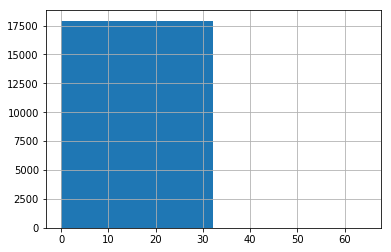

In [92]:
import matplotlib
#matplotlib.pyplot.scatter(engt_df['engagement_score'])

engt_df['engagement_score'].hist(bins=2)

In [95]:
q3=np.percentile(engt_df['engagement_score'], 75)
top_quartile=engt_df[engt_df['engagement_score']>q3]


In [98]:
y_eng_top= engt_df['engagement_score']
X_eng_top=engt_df[['glasdoor_ceo_approval',  'sentiment_score', 

 'apple', 'tesla', 'mahindra', 'boeing', 'spotify', 'tmobile', 'google', 'box',
 'goldman', 'dell',  'news_corp',  'microsoft', 'schwabs',  'yahoo',
 'okta', 'twitter', 'workday', 'general1_motors',
 'dropbox', 'pepsico', 'westernunion', 'cisco', 'amazon', 'amd']]

In [99]:
#Engagement model-top quartile
eng_model_top = sm.OLS(y_eng_top, X_eng_top).fit()
eng_model_top.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     36.08
Date:                Fri, 07 Aug 2020   Prob (F-statistic):          1.14e-169
Time:                        10:39:30   Log-Likelihood:                -35645.
No. Observations:               17933   AIC:                         7.134e+04
Df Residuals:                   17907   BIC:                         7.154e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.1845      0.038      4.815      0.000       0.109       0.260
sentiment_score          -0.1161      0.046     -2.543      0.011      -0.206      -0.027
apple                     0.5519      0.093      5.916      0.000       0.369       0.735
tesla                     1.1148      0.052     21.427      0.000       1.013       1.217
mahindra                  0.0506      0.052      0.969      0.333      -0.052       0.153
boeing                   -0.0918      0.093     -0.983      0.325      -0.275       0.091
spotify                  -0.1119      0.122     -0.916      0.360      -0.351       0.127
tmobile                  -0.1435      0.052     -2.775      0.006      -0.245      -0.042
google                    0.0732      0.099      0.742      0.458      -0.120       0.267
box                       0.0976      0.091      1.068      0.286      -0.082       0.277
goldman                   0.1711      0.225      0.759      0.448      -0.271       0.613
dell                     -0.1165      0.071     -1.644      0.100      -0.255       0.022
news_corp                -0.0869      1.767     -0.049      0.961      -3.551       3.377
microsoft                -0.0792      0.089     -0.888      0.375      -0.254       0.096
schwabs                  -0.1254      0.093     -1.342      0.180      -0.308       0.058
yahoo                     0.2119      0.225      0.942      0.346      -0.229       0.653
okta                     -0.1498      0.167     -0.896      0.370      -0.477       0.178
twitter                   0.1254      0.047      2.644      0.008       0.032       0.218
workday                  -0.0222      0.192     -0.116      0.908      -0.398       0.354
general1_motors          -0.0577      0.130     -0.443      0.658      -0.313       0.197
dropbox                  -0.1257      0.309     -0.406      0.685      -0.732       0.481
pepsico                  -0.1054      0.178     -0.592      0.554      -0.454       0.243
westernunion              0.1095      0.069      1.585      0.113      -0.026       0.245
cisco                    -0.1162      0.071     -1.634      0.102      -0.255       0.023
amazon                    0.4826      0.167      2.885      0.004       0.155       0.810
amd                      -0.0733      0.154     -0.477      0.633      -0.374       0.228
==============================================================================
Omnibus:                    37330.470   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        158698376.007
Skew:                          17.855   Prob(JB):                         0.00
Kurtosis:                     462.470   Cond. No.                         133.
==============================================================================

In [100]:
#Binning :
engagement_median = engt_df['engagement_score'].median()
engt_df["engagement"] = engt_df['engagement_score'].apply(lambda x: 1 if x > engagement_median else 0)

C:\Users\Nimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
#clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_eng_top,engt_df["engagement"] ) 

logit1 = sm.Logit(engt_df["engagement"], X_eng_top)
result = logit1.fit()
result.summary()

         Current function value: 0.468870
         Iterations: 35


C:\Users\Nimesh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             engagement   No. Observations:                17933
Model:                          Logit   Df Residuals:                    17907
Method:                           MLE   Df Model:                           25
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                  0.3236
Time:                        10:40:11   Log-Likelihood:                -8408.3
converged:                      False   LL-Null:                       -12430.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval    -0.8789      0.048    -18.418      0.000      -0.972      -0.785
sentiment_score          -0.0872      0.065     -1.347      0.178      -0.214       0.040
apple                     6.8546      1.002      6.840      0.000       4.890       8.819
tesla                    34.8861   5.19e+05   6.72e-05      1.000   -1.02e+06    1.02e+06
mahindra                  1.8602      0.066     28.298      0.000       1.731       1.989
boeing                   -0.1916      0.117     -1.642      0.101      -0.420       0.037
spotify                  -1.0616      0.197     -5.375      0.000      -1.449      -0.675
tmobile                  -0.5043      0.069     -7.346      0.000      -0.639      -0.370
google                    2.7943      0.164     17.078      0.000       2.474       3.115
box                       1.5508      0.112     13.892      0.000       1.332       1.770
goldman                   4.9665      1.009      4.922      0.000       2.989       6.944
dell                      0.5829      0.083      7.038      0.000       0.421       0.745
news_corp               -11.6453    419.053     -0.028      0.978    -832.973     809.683
microsoft                 2.4845      0.131     18.906      0.000       2.227       2.742
schwabs                  -4.1187      0.581     -7.090      0.000      -5.257      -2.980
yahoo                     0.2778      0.262      1.059      0.290      -0.237       0.792
okta                     -3.9113      1.005     -3.891      0.000      -5.882      -1.941
twitter                   0.6198      0.056     11.034      0.000       0.510       0.730
workday                  -0.4263      0.263     -1.621      0.105      -0.942       0.089
general1_motors           0.0877      0.152      0.577      0.564      -0.210       0.386
dropbox                  -0.0269      0.381     -0.070      0.944      -0.774       0.720
pepsico                   0.2819      0.208      1.358      0.175      -0.125       0.689
westernunion             -1.8177      0.136    -13.360      0.000      -2.084      -1.551
cisco                     0.0686      0.087      0.784      0.433      -0.103       0.240
amazon                   21.3696   2748.119      0.008      0.994   -5364.844    5407.583
amd                       2.3772      0.222     10.689      0.000       1.941       2.813
=========================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""